# Plotting external validation results
This notebook plots predictions from the trained bagging model on the training, test, and externally measured molecules.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
sns.set_context('talk', font_scale=1.5)
sns.set(color_codes=True)

%matplotlib inline

/Users/pstjohn/anaconda3/envs/ysi/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/pstjohn/anaconda3/envs/ysi/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    from ysi_utils.models import outlier_model, bagging_model, ensemble_predict
    ensemble_predict.bagging_model = bagging_model()

Using Theano backend.


In [3]:
from ysi_utils.data import low
from ysi_utils.descriptors import dragon
from ysi_utils.validation import y_train as y
from ysi_utils.validation import y_test

X = dragon.loc[y.index]
X_test = dragon.loc[y_test.index]

y_test_predictions = ensemble_predict(X_test)
y_train_predictions = ensemble_predict(X.values)

In [4]:
y_train_predictions.shape

(238, 25)

In [5]:
from ysi_utils.tools import chemical_conversions

addl_molecules = [
    ['cyclopentanone',        '120-92-3'],
    ['2-methylbut-3-en-2-ol', '115-18-4'],
    ['2,5-dimethylfuran',     '625-86-5'],
]

molecule_df = pd.DataFrame(addl_molecules, columns=['Name', 'CAS'])
molecule_df['SMILES'] = molecule_df.CAS\
    .apply(chemical_conversions.get_smiles_from_cas, db='nist')\
    .apply(chemical_conversions.canonicalize_smiles)
    
molecule_df['YSI'] = [-11.66, -6.78, 35.37]
# molecule_df.to_pickle('../ysi_utils/data/addl_mols.p')
molecule_df

,Name,CAS,SMILES,YSI
0,cyclopentanone,120-92-3,O=C1CCCC1,-11.66
1,2-methylbut-3-en-2-ol,115-18-4,C=CC(C)(C)O,-6.78
2,"2,5-dimethylfuran",625-86-5,Cc1ccc(C)o1,35.37


In [7]:
y_exp_pred = ensemble_predict(dragon.loc[molecule_df.SMILES])

In [8]:
y['inlier'] = outlier_model.predict(X) == 1
y_test['inlier'] = outlier_model.predict(X_test) == 1
molecule_df['inlier'] = outlier_model.predict(dragon.loc[molecule_df.SMILES]) == 1

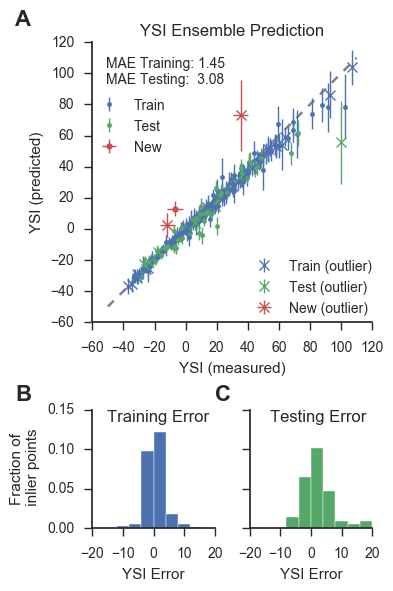

In [9]:
from matplotlib import gridspec
from sklearn.metrics import median_absolute_error

with sns.axes_style('ticks'):
    
    fig = plt.figure(figsize=(4,6))
    gs = gridspec.GridSpec(3,2)
    
    ax = fig.add_subplot(gs[:2,:2], aspect='equal')
    ax2 = fig.add_subplot(gs[2, 0])
    ax3 = fig.add_subplot(gs[2, 1], sharey=ax2)
    plt.setp(ax3.get_yticklabels(), visible=False)


    ax.set_xlim([-60, 120])
    ax.set_ylim([-60, 120])


    train_in = ax.errorbar(y.loc[y.inlier, 'YSI'], y_train_predictions[y.inlier.values].mean(1),
                yerr=1.96*y_train_predictions[y.inlier.values].std(1), fmt='.', label='Train', lw=1., color='b')
    test_in = ax.errorbar(y_test.loc[y_test.inlier, 'YSI'], y_test_predictions[y_test.inlier.values].mean(1),
                yerr=1.96*y_test_predictions[y_test.inlier.values].std(1), fmt='.', label='Test', lw=1., color='g')

    train_out = ax.errorbar(y.loc[~y.inlier, 'YSI'], y_train_predictions[~y.inlier.values].mean(1),
                yerr=1.96*y_train_predictions[~y.inlier.values].std(1), fmt='x', label='Train (outlier)', lw=1.,
                markeredgewidth=1, color='b', capsize=0)
    test_out = ax.errorbar(y_test.loc[~y_test.inlier, 'YSI'], y_test_predictions[~y_test.inlier.values].mean(1),
                yerr=1.96*y_test_predictions[~y_test.inlier.values].std(1), fmt='x', label='Test (outlier)', lw=1.,
                markeredgewidth=1., color='g', capsize=0)

    exp_in = ax.errorbar(molecule_df[molecule_df.inlier].YSI, y_exp_pred[molecule_df.inlier.values].mean(1),
                yerr=1.96*y_exp_pred[molecule_df.inlier.values].std(1), fmt='.', label='New',
                color='r', zorder=5, markeredgewidth=1., lw=1., capsize=0, xerr=5)
    exp_out = ax.errorbar(molecule_df[~molecule_df.inlier].YSI, y_exp_pred[~molecule_df.inlier.values].mean(1),
                yerr=1.96*y_exp_pred[~molecule_df.inlier.values].std(1), xerr=5, fmt='x', zorder=5,
                label='New (outlier)', lw=1., markeredgewidth=1., color='r', capsize=0)
    
    
    #ax.text(molecule_df.YSI.iloc[0]-2, y_exp_pred.mean(1)[0], '*', ha='right', va='center', size=20)
    
    
    ax.plot([-50, 110], [-50, 110], '--', zorder=0, color='gray')


    ax.set_ylabel('YSI (predicted)')
    ax.set_xlabel('YSI (measured)')

    
    ax.set_title('YSI Ensemble Prediction')
    
    
    text = ('MAE Training: {:.2f}'.format(median_absolute_error(
                y.loc[y.inlier, 'YSI'],
                y_train_predictions[y.inlier.values].mean(1))) + '\n' +
            'MAE Testing:  {:.2f}'.format(median_absolute_error(
                y_test.loc[y_test.inlier, 'YSI'],
                y_test_predictions[y_test.inlier.values].mean(1))))
    
    ax.text(0.05, 0.95, text, transform=ax.transAxes, ha='left', va='top')
    
    first_legend = ax.legend(handles=[train_in, test_in, exp_in], loc='upper left',
                             bbox_to_anchor=(0.01, 0.8),
                             borderpad=0, borderaxespad=0)

    ax.add_artist(first_legend)
    ax.legend(handles=[train_out, test_out, exp_out], loc='lower right', bbox_to_anchor=(1., 0.025),
             borderpad=0, borderaxespad=0)


    ax2.hist((y.loc[y.inlier, 'YSI'] - y_train_predictions[y.inlier.values].mean(1)),
             edgecolor='w', range=(-20, 20), normed=True)
    ax3.hist((y_test.loc[y_test.inlier, 'YSI'] - y_test_predictions[y_test.inlier.values].mean(1)),
             edgecolor='w', facecolor='g', range=(-20, 20), normed=True)

    ax2.set_xlabel('YSI Error')
    ax3.set_xlabel('YSI Error')
    
    ax2.text(0.95, 1., 'Training Error', transform=ax2.transAxes, ha='right', va='top', fontsize='large')
    ax3.text(0.95, 1., 'Testing Error', transform=ax3.transAxes, ha='right', va='top', fontsize='large')  

    ax2.set_ylabel('Fraction of\n inlier points')
    #ax3.set_ylabel('Number of inlier points')

    ax2.set_xticks([-20, -10, 0, 10, 20])
    
    ax2.set_ylim([0, .15])
    ax2.set_yticks([0., 0.05, 0.10, 0.15])
    
    ax3.set_xticks([-20, -10, 0, 10, 20])

    
#    ax2.set_ylim([0, 154])

    sns.despine()
    fig.tight_layout()
    fig.text(0.05, .975, 'A', va='top', ha='left', fontsize=16, fontweight='bold')
    fig.text(0.05, .35, 'B', va='top', ha='left', fontsize=16, fontweight='bold')
    fig.text(0.55, .35, 'C', va='top', ha='left', fontsize=16, fontweight='bold')


#     fig.savefig('ysi_prediction_with_exp.svg', transparent=True)

In [10]:
median_absolute_error(
                y_test.loc[y_test.inlier, 'YSI'],
                y_test_predictions[y_test.inlier.values].mean(1))

3.0774892425537139

In [13]:
(y_test.loc[y_test.inlier, 'YSI'] - y_test_predictions[y_test.inlier.values].mean(1)).std()

5.3249597477133594

In [16]:
(y_test.loc[y_test.inlier, 'YSI'] - y_test_predictions[y_test.inlier.values].mean(1)).std() * 1.96

10.436921105518184

In [14]:
import pymc3

In [15]:
pymc3.hpd((y_test.loc[y_test.inlier, 'YSI'] - y_test_predictions[y_test.inlier.values].mean(1)))

array([ -6.8018631 ,  14.84413528])